## OpenAI gym FrozenLake-v0 (deterministic)
---
[FrozenLake-v0 doc](https://gym.openai.com/envs/FrozenLake-v0/)

[FrozenLake-v0 src](https://github.com/openai/gym/tree/master/gym/envs/toy_text/frozen_lake.py)

---

#### Descripción
El agente controla el movimiento de un personaje en una cuadrícula (4x4). Algunas de las celdas son transitables, mientras que otras hacen que el agente caiga en el agua. Además, la dirección de movimiento del puede ser incierta y depende, sólo parcialmente, en la dirección elegida (stochastic vs deterministic).

La superficie sobre la que se desplaza el agente se describe usando una matriz como la siguiente:

<br>

| GRID | Tipo de Celda |
| --- | --- |
| **S**FFF | (**S**: celda de inicio, segura) |
| F**H**F**H** | (**F**: celda transitable, segura) |
| FFF**H** | (**H**: agujero, caída del agente) |
| **H**FF**G** | (**G**: destino, celda objetivo) |

<br>

Un episodio finaliza cuando se alcanza el destino o el agente cae en un agujero.
El agente es recompensado por encontrar una camino transitable al destino.

<br>

#### Observaciones
Existen 16 (4x4) estados, correspondiéndose con la localización actual del agente en la cuadrícula.

Los estados están numerados secuencialmente de 0 a 15 (0-3 primera fila de la cuadrícula, 4-7 segunda fila,...).

<br>

#### Acciones
El espacio discreto de acciones que puede tomar el agente es el siguiente:

- 0: izquierda
- 1: abajo
- 2: derecha
- 4: arriba

<br>

#### Recompensas
El agente recibe una recompensa de +1 si alcanza el destino. Cualquier otra situación no recibe ninguna recompensa.

###### NOTA: 
Con objeto de ver como el sistema de recompensas afecta al entrenamiento del agente, se modificará el sistema de recompensas para establecer recompensas negativas cuando toma acciones que lo llevarían fuera del grid o que provocan que caiga en un agujero.

### Demo
---
La siguiente demo muestra la creación de un _wrapper_ del entorno basado en _pygame_ y la ejecución de una serie de episodios (_EPISODES) en el que el agente se desplazará de forma aleatoria

In [1]:
# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import time

_EPISODES = 5

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=False, sound=True)

for i in range(_EPISODES):
    print(f"Episode {i+1}")
    
    env.reset()     # reset environment
    env.run_once()  # render window and process events
    
    time.sleep(0.5)
    
    done = False
    while env.is_alive and not done:
        action = env.action_space.sample()   # sample a random action
        obs, rew, done, _ = env.step(action) # take action
        
        env.run_once()
        time.sleep(0.25)
    time.sleep(0.5) # end of episode

# wait for windows close event
while env.is_alive:
    env.run_once()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5


### Resolviendo la ecuación de Bellman
---
Dado que se trata de un espacio MDP (_Markov Decission Process_), donde el "valor" de un estado concreto y de la acción que tomemos sólo depende de las recompensas futuras (y no de cómo llegamos a dicho estado), podemos aplicar la ecuación de Bellman para tratar de determinar el **Q-value** de cada pareja (estado _s_, acción _a_), es decir, cuánto de bueno es tomar una acción **_a_** estando en el estado **_s_**.

<br>

![bellman.png](bellman.png)

<br>

De la ecuación anterior observamos que el **Q-valor** de una pareja (_s_, _a_), donde _s_ es el estado actual y _a_ una acción que puedo tomar desde ese estado y que me llevará a un nuevo estado _s'_, vendrá dado por la recompensa obtenida (_r_) más el máximo del valor de las futuras acciones (_a'_) que pueda tomar desde el nuevo estado (_s'_).

Una vez obtenidos los valores de las distintas parejas (_s_, _a_) mediante entrenamiento en el entorno, podré aplicar una política (_policy_) de acción óptima, simplemente seleccionando, para el estado actual, aquella que presente un mayor _Q-value_, es decir, aquella que me lleve a estados de más valor (más recompensa futura).

Para resolver la ecuación enterior y determinar los _Q-values_, aplicaremos un algoritmo iterativo, tipo Monte Carlo. Por cada iteración, seleccionaremos una acción y, en función de la recompensa y acción seleccionada, iremos actualizando los distintos _Q-values_. Si bien esta acción podría seleccionarse de forma aleatoria, en nuestro caso seleccionaremos la opción óptima de forma que el propio agente se comporte de forma óptima al final del aprendizaje.

<br>

##### Algoritmo:

<br>

```pascal
initialize Q[num_states, num_actions]
observe initial state s
    
repeat until terminated:
    select and perform action a
    observe reward r and new state s'
    Q(s,a) = r + 𝛾 * max Q(s', a')
    s = s'
```

<br>
  
El factor de descuento, 𝛾, es un número habitualmente en el intervalo \[0, 1). En este caso, al tratarse de un entorno determinista y de episodios finitos, podemos usar 𝛾 = 1


Episode:
000 001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 
025 026 027 028 029 030 031 032 033 034 035 036 037 038 039 040 041 042 043 044 045 046 047 048 049 
050 051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074 
075 076 077 078 079 080 081 082 083 084 085 086 087 088 089 090 091 092 093 094 095 096 097 098 099 
100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 
125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 
175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 
225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 2

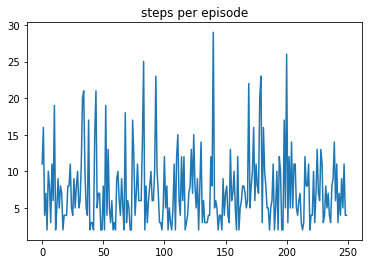


Average reward:  0.012
Last-50 avg reward:  0.02


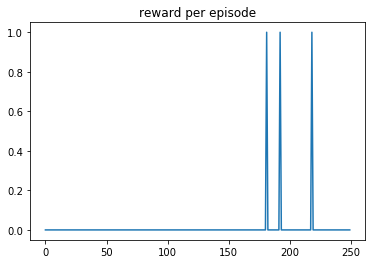

In [2]:
# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import time
import torch
from matplotlib import pyplot as plt

_EPISODES = 250
_GAMMA = 1  # deterministic environment and finite episodes

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=False, sound=True)
env.set_im_goal('art/batt.png')

env.hole_color = (25, 25, 25)
env.grid_color = (220, 220, 255)
env.home_color = (200, 255, 200)
env.goal_color = (255, 200, 200)

# Q-values
Q = torch.zeros((env._env.nS, env._env.nA))

# stats
episodes_rewards = []
episodes_steps = []

print("\nEpisode:", end="") 
for i in range(_EPISODES):
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
    env.run_once()
    time.sleep(0.25)
    
    if i%25==0: print()
    print(f"{i:03d} ", end="")
    
    done = False  # episode done?
    while env.is_alive and not done:
        # select action with greatest Q-value for the current state
        # we have added some randomness because of the initial 0.0 values of the matrix
        # dim=1 calculates the maximum of each row (per columns)
        # max() returns two tensors: 
        #    [0]: tensor of maximum values per row (dim=1)
        #    [1]: tensor of column index (action) with maximum value of each row (dim=1)
        action = torch.max(Q + torch.randn(env._env.nA)/1E3, dim=1)[1][state].item()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        # we add the maximum Q-value of the new state
        Q[state, action] = reward + _GAMMA*torch.max(Q, dim=1)[0][new_state].item()
        
        # update state
        state = new_state
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        
        # update window
        env.run_once()
        time.sleep(0.15)
    
    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    if not env.is_alive:
        break
        
# show Q-values
print("\n\nQ-values:\n" + "-"*(6*Q.shape[1] - 1))
for r in range(Q.shape[0]):
    for c in range(Q.shape[1]):
        print(f"{Q[r,c]:5.2f} ",end="")
    print()
    if (r+1) % Q.shape[1] == 0:
        print("-"*(6*Q.shape[1] - 1))
        
# show stats
print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
print(f"Last-50 avg steps: ", sum(episodes_steps[-50:])/50)
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))
print(f"Last-50 avg reward: ", sum(episodes_rewards[-50:])/50)
plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()

# wait until window closes
while env.is_alive:
    env.run_once()

### Recompensa y Aprendizaje
---
Por defecto, el entorno anterior sólo proporciona una recompensa cuando se alcanza la celda objetivo (+1). Por ello, observamos como durante gran cantidad de episodios el comportamiento es puramente aleatorio, pues el agente no tiene aún información suficiente del entorno. Sólo a partir de los primeros episodios en que alcance la meta podrá ir actualizando los _Q-values_ de los estados. Por esta misma razón, observamos como continuamente cae en las "celdas agujero" o selecciona acciones que lo llevarían fuera del tablero.

Podríamos mejorar su comportamiento y, al mismo tiempo, reducir el tiempo de aprendizaje, proporcionando **recompesas negativas** para las situaciones indeseables descritas anteriormente.


Episode:
000 001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 
025 026 027 028 029 030 031 032 033 034 035 036 037 038 039 040 041 042 043 044 045 046 047 048 049 

Q-values:
-----------------------
-0.10  1.00  0.00 -0.10 
 0.00 -0.20  0.00 -0.10 
 0.00  0.00  0.00 -0.10 
 0.00 -0.20 -0.10 -0.10 
-----------------------
-0.10  1.00 -0.20  0.00 
 0.00  0.00  0.00  0.00 
-0.20  1.00 -0.20  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
-0.10 -0.20  1.00  0.00 
 0.00  1.00  0.00 -0.20 
 0.00  1.00 -0.20  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
 0.00  0.00  0.00  0.00 
-0.20 -0.10  1.00  0.00 
 0.00 -0.10  1.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------

Average steps:  11.1
Last-10 avg steps:  6.0


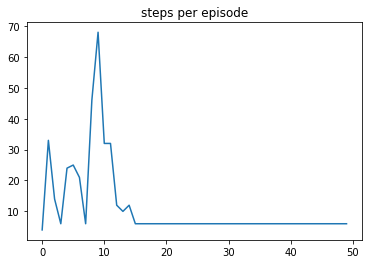


Average reward:  0.764
Last-10 avg reward:  1.0


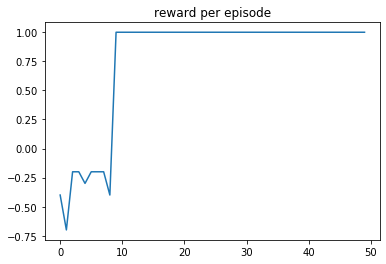

In [3]:
# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import time
import torch
from matplotlib import pyplot as plt

_EPISODES = 50
_GAMMA = 1  # deterministic environment and finite episodes

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=False, sound=True)
env.set_im_goal('art/batt.png')

# negative rewards
env.rewd_hole = -0.2  # fall into the hole reward
env.rewd_wall = -0.1  # stumble into the wall

env.hole_color = (25, 25, 25)
env.grid_color = (220, 220, 255)
env.home_color = (200, 255, 200)
env.goal_color = (255, 200, 200)

# Q-values
Q = torch.zeros((env._env.nS, env._env.nA))

# stats
episodes_rewards = []
episodes_steps = []

print("\nEpisode:", end="") 
for i in range(_EPISODES):
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
    env.run_once()
    time.sleep(0.25)
    
    if i%25==0: print()
    print(f"{i:03d} ", end="")
    
    done = False  # episode done?
    while env.is_alive and not done:
        # select action with greatest Q-value for the current state
        # we have add some randomness because of the initial 0.0 values of the matrix
        # dim=1 calculates the maximum of each row (per columns)
        # max() returns two tensors: 
        #    [0]: tensor of maximum values per row (dim=1)
        #    [1]: tensor of column index with maximum value of each row (dim=1)
        action = torch.max(Q + torch.randn(env._env.nA)/1E3, dim=1)[1][state].item()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        # we add the maximum Q-value of the new state
        Q[state, action] = reward + _GAMMA*torch.max(Q, dim=1)[0][new_state].item()
        
        # update state
        state = new_state
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        
        # update window
        env.run_once()
        time.sleep(0.15)
    
    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    if not env.is_alive:
        break
        
# show Q-values
print("\n\nQ-values:\n" + "-"*(6*Q.shape[1] - 1))
for r in range(Q.shape[0]):
    for c in range(Q.shape[1]):
        print(f"{Q[r,c]:5.2f} ",end="")
    print()
    if (r+1) % Q.shape[1] == 0:
        print("-"*(6*Q.shape[1] - 1))
        
# show stats
print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
print(f"Last-10 avg steps: ", sum(episodes_steps[-10:])/10)
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))
print(f"Last-10 avg reward: ", sum(episodes_rewards[-10:])/10)
plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()

# wait until window closes
while env.is_alive:
    env.run_once()

### Almacenando el modelo
---
El entrenamiento de un agente puede requerir, en función de la complejidad del entorno y la solución del problema, un gran esfuerzo computacional en tiempo y recursos. Sin embargo, una vez finalizado el entrenamiento, podemos salvar el modelo "aprendido" por el agente para utilizarlo posteriormente, sin necesidad de entrenarlo de nuevo.

En el siguiente ejemplo, volveremos a entrenar a nuestro agente pero, esta vez, guardaremos el modelo entrenado en un archivo _.csv_. A continuación, crearemos una nueva instancia del agente pero, esta vez, con el modelo precargado.

In [4]:
# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import time
import torch
import numpy as np

class FrozenLakeAgent():
    """Agent class for FrozenLake environment.
    """
    def __init__(self, nS, nA, train=False, gamma=1.0):
        self._nS = nS
        self._nA = nA
        self._train = train
        self._gamma = gamma
        self._state = 0
        self._Q = torch.zeros((nS, nA))
        
    def reset(self, state):
        self._state = state
        
    def get_action(self):
        return torch.max(self._Q + torch.randn(self._nA)/1E3, dim=1)[1][self._state].item()

    def update(self, new_state, r, action):
        if self._train:
            # update Q-value
            self._Q[self._state, action] = r + self._gamma*torch.max(self._Q, dim=1)[0][new_state].item()
        self._state = new_state
        
    def load_model(self, file_name):
        nQ = np.loadtxt(file_name, dtype=np.float32, delimiter=";")
        self._Q = torch.from_numpy(nQ)
        
    def save_model(self, file_name):
        np.savetxt(file_name, self._Q.detach().cpu().numpy(), delimiter=";")
        
    def print_model(self):
        # show Q-values
        print("\n\nQ-values:\n" + "-"*(6*Q.shape[1] - 1))
        for r in range(Q.shape[0]):
            for c in range(Q.shape[1]):
                print(f"{Q[r,c]:5.2f} ",end="")
            print()
            if (r+1) % Q.shape[1] == 0:
                print("-"*(6*Q.shape[1] - 1))
        
_EPISODES = 40

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=False, sound=True)
env.set_im_goal('art/batt.png')

# negative rewards
env.rewd_hole = -0.2  # fall into the hole reward
env.rewd_wall = -0.1  # stumble into the wall

env.hole_color = (25, 25, 25)
env.grid_color = (220, 220, 255)
env.home_color = (200, 255, 200)
env.goal_color = (255, 200, 200)

# Agent
agent = FrozenLakeAgent(env._env.nS, env._env.nA, train=True, gamma=1)

print("Training...")
print("\nEpisode:", end="") 
for i in range(_EPISODES):
    state = env.reset() # initial state
    agent.reset(state)
    env.run_once()
    time.sleep(0.2)
    
    if i%10==0: print()
    print(f"{i:03d}\t", end="")
    
    done = False  # episode done?
    while env.is_alive and not done:
        # get action
        action = agent.get_action()
              
        # perform action
        new_state, reward, done, _ = env.step(action)
        
        # update Q-values
        agent.update(new_state, reward, action)
        
        # update window
        env.run_once()
        time.sleep(0.1)
    
    if not env.is_alive:
        break

# print model
agent.print_model()

# save model
agent.save_model("frozenlake_det_model.csv")

# wait until window closes
while env.is_alive:
    env.run_once()

Training...

Episode:
000	001	002	003	004	005	006	007	008	009	
010	011	012	013	014	015	016	017	018	019	
020	021	022	023	024	025	026	027	028	029	
030	031	032	033	034	035	036	037	038	039	

Q-values:
-----------------------
-0.10  1.00  0.00 -0.10 
 0.00 -0.20  0.00 -0.10 
 0.00  0.00  0.00 -0.10 
 0.00 -0.20 -0.10 -0.10 
-----------------------
-0.10  1.00 -0.20  0.00 
 0.00  0.00  0.00  0.00 
-0.20  1.00 -0.20  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
-0.10 -0.20  1.00  0.00 
 0.00  1.00  0.00 -0.20 
 0.00  1.00 -0.20  0.00 
 0.00  0.00  0.00  0.00 
-----------------------
 0.00  0.00  0.00  0.00 
-0.20 -0.10  1.00  0.00 
 0.00 -0.10  1.00  0.00 
 0.00  0.00  0.00  0.00 
-----------------------


Ahora, vamos a hacer que nuestro agente resuelva varios episodios, pero cargando previamente el modelo:

In [5]:
_EPISODES = 3

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=False, sound=True)
env.set_im_goal('art/batt.png')

env.hole_color = (25, 25, 25)
env.grid_color = (220, 220, 255)
env.home_color = (200, 255, 200)
env.goal_color = (255, 200, 200)

# Agent
agent = FrozenLakeAgent(env._env.nS, env._env.nA, train=False, gamma=1)

# load model
agent.load_model("frozenlake_det_model.csv")

for i in range(_EPISODES):
    print(f"\nEpisode: {i+1}... ", end="")
    
    # initial state
    state = env.reset() 
    agent.reset(state)
    
    env.run_once()
    time.sleep(1)
    
    done = False  # episode done?
    while env.is_alive and not done:
        # perform action
        new_state, reward, done, _ = env.step(agent.get_action())
        
        # update agent state
        agent.update(new_state, reward, action)
        
        # update window
        env.run_once()
        time.sleep(0.25)
    
    print("done")
    time.sleep(1)
    
    if not env.is_alive:
        break

# wait until window closes
while env.is_alive:
    env.run_once()


Episode: 1... done

Episode: 2... done

Episode: 3... done
